# Введение в искусственные нейронные сети
# Урок 3. TensorFlow

## Практическое задание

<ol>
    <li>Попробуйте обучить нейронную сеть на TensorFlow 2 на любом датасете imdb_reviews. 
        Опишите в комментарии к уроку - какой результата вы добились от нейросети? Что помогло вам улучшить ее точность?<br><br>
    </li>
    <li>*2. Поработайте с документацией TensorFlow 2. Найдите полезные команды не разобранные на уроке.</li>
    
    
</ol>

Использовалось задание https://github.com/kesch9/NN_Base/blob/83abacc83af47a0821e3754e8ccedcf567e8152f/Lesson_3/Task_3.ipynb
с разбором функций


In [80]:
from __future__ import absolute_import, division, print_function, unicode_literals

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
import tensorflow_hub as hub
import datetime
import pydot


# Helper libraries
import numpy as np
import matplotlib.pyplot as plt


print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
# print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.experimental.list_physical_devices("GPU") else "NOT AVAILABLE")

Version:  2.2.0
Eager mode:  True
GPU is NOT AVAILABLE


In [28]:
# Разобьем обучающую выборку 
# https://www.tensorflow.org/datasets/api_docs/python/tfds/load - про параметры загрузки и разбивки сета
train_data, validation_data, test_data = tfds.load(  
    name="imdb_reviews", 
    split=('train[:70%]', 'train[10%:80%]', 'test[90%:]'),
    as_supervised=True)


train_examples_batch, train_labels_batch = next(iter(train_data.batch(15)))
# print(train_examples_batch)
train_labels_batch

<tf.Tensor: shape=(15,), dtype=int64, numpy=array([0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1])>

In [42]:
embedding = "https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1"
# https://habr.com/ru/company/ods/blog/329410/ -  про пространство слов-векторов

# сделали слой с векторами слов по 20 измерениям
hub_layer = hub.KerasLayer(embedding, input_shape=[], 
                           dtype=tf.string, trainable=True)

hub_layer(train_examples_batch[:2])

<tf.Tensor: shape=(2, 20), dtype=float32, numpy=
array([[ 1.765786  , -3.882232  ,  3.9134233 , -1.5557289 , -3.3362343 ,
        -1.7357955 , -1.9954445 ,  1.2989551 ,  5.081598  , -1.1041286 ,
        -2.0503852 , -0.72675157, -0.65675956,  0.24436149, -3.7208383 ,
         2.0954835 ,  2.2969332 , -2.0689783 , -2.9489717 , -1.1315987 ],
       [ 1.8804485 , -2.5852382 ,  3.4066997 ,  1.0982676 , -4.056685  ,
        -4.891284  , -2.785554  ,  1.3874227 ,  3.8476458 , -0.9256538 ,
        -1.896706  ,  1.2113281 ,  0.11474707,  0.76209456, -4.8791065 ,
         2.906149  ,  4.7087674 , -2.3652055 , -3.5015898 , -1.6390051 ]],
      dtype=float32)>

In [54]:
# Параметры нейросети
model = tf.keras.Sequential()
model.add(hub_layer) # подгрузили слой с векторами 

# https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense
# model.add(tf.keras.layers.Dense(20, activation='relu')) # полносвязный слой с 20 нейронами  
model.add(tf.keras.layers.Dense(16, activation='relu')) # полносвязный слой с 16 нейронами  
model.add(tf.keras.layers.Dense(1, activation='sigmoid')) # выходной слой

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_6 (KerasLayer)   (None, 20)                400020    
_________________________________________________________________
dense_11 (Dense)             (None, 16)                336       
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 17        
Total params: 400,373
Trainable params: 400,373
Non-trainable params: 0
_________________________________________________________________


In [68]:
# альтернативный способ собрать слои нейросети
model = keras.Sequential([
    hub_layer,
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid') # сигмоида срабатывает лучше чем softmax
])

model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_6 (KerasLayer)   (None, 20)                400020    
_________________________________________________________________
dense_15 (Dense)             (None, 128)               2688      
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 129       
Total params: 402,837
Trainable params: 402,837
Non-trainable params: 0
_________________________________________________________________


In [69]:
'''
Loss function — меряет как точно работает нейросеть.
Optimizer — определяет способ корректировки весов.
Metrics — определяет какие характеристики будут отражаться в процессе обучения.
'''
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])




In [47]:
history = model.fit(train_data.shuffle(10000).batch(512),
                    epochs=20,
                    validation_data=validation_data.batch(512),
                    verbose=1)

Epoch 1/20
35/35 [==============================] - 3s 77ms/step - loss: 0.8241 - accuracy: 0.5133 - val_loss: 0.7137 - val_accuracy: 0.5697
Epoch 2/20
35/35 [==============================] - 3s 75ms/step - loss: 0.6672 - accuracy: 0.6103 - val_loss: 0.6210 - val_accuracy: 0.6637
Epoch 3/20
35/35 [==============================] - 4s 114ms/step - loss: 0.5925 - accuracy: 0.6925 - val_loss: 0.5679 - val_accuracy: 0.7133
Epoch 4/20
35/35 [==============================] - 3s 84ms/step - loss: 0.5485 - accuracy: 0.7287 - val_loss: 0.5322 - val_accuracy: 0.7439
Epoch 5/20
35/35 [==============================] - 3s 90ms/step - loss: 0.5122 - accuracy: 0.7586 - val_loss: 0.4948 - val_accuracy: 0.7722
Epoch 6/20
35/35 [==============================] - 3s 92ms/step - loss: 0.4753 - accuracy: 0.7852 - val_loss: 0.4585 - val_accuracy: 0.7987
Epoch 7/20
35/35 [==============================] - 3s 73ms/step - loss: 0.4388 - accuracy: 0.8089 - val_loss: 0.4224 - val_accuracy: 0.8201
Epoch 8/20
3

In [56]:
history = model.fit(train_data.shuffle(10000).batch(512),
                    epochs=5,
                    validation_data=validation_data.batch(512),
                    verbose=1)

Epoch 1/5
35/35 [==============================] - 3s 92ms/step - loss: 0.6647 - accuracy: 0.6265 - val_loss: 0.5776 - val_accuracy: 0.7163
Epoch 2/5
35/35 [==============================] - 3s 74ms/step - loss: 0.5271 - accuracy: 0.7606 - val_loss: 0.4829 - val_accuracy: 0.7981
Epoch 3/5
35/35 [==============================] - 3s 72ms/step - loss: 0.4438 - accuracy: 0.8229 - val_loss: 0.4123 - val_accuracy: 0.8401
Epoch 4/5
35/35 [==============================] - 3s 72ms/step - loss: 0.3766 - accuracy: 0.8590 - val_loss: 0.3523 - val_accuracy: 0.8687
Epoch 5/5
35/35 [==============================] - 3s 73ms/step - loss: 0.3205 - accuracy: 0.8835 - val_loss: 0.3042 - val_accuracy: 0.8898


In [76]:
# https://www.tensorflow.org/tensorboard/get_started

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


history = model.fit(train_data.shuffle(10000).batch(512),
                    epochs=5,
                    validation_data=validation_data.batch(512),
                    verbose=1, 
                    callbacks=[tensorboard_callback])

Epoch 1/5
35/35 [==============================] - 3s 85ms/step - loss: 0.1216 - accuracy: 0.9605 - val_loss: 0.1466 - val_accuracy: 0.9475
Epoch 2/5
35/35 [==============================] - 4s 119ms/step - loss: 0.1121 - accuracy: 0.9636 - val_loss: 0.1393 - val_accuracy: 0.9522
Epoch 3/5
35/35 [==============================] - 4s 102ms/step - loss: 0.1047 - accuracy: 0.9644 - val_loss: 0.1316 - val_accuracy: 0.9550
Epoch 4/5
35/35 [==============================] - 3s 97ms/step - loss: 0.0969 - accuracy: 0.9683 - val_loss: 0.1263 - val_accuracy: 0.9572
Epoch 5/5
35/35 [==============================] - 4s 119ms/step - loss: 0.0893 - accuracy: 0.9713 - val_loss: 0.1228 - val_accuracy: 0.9600


In [49]:
results = model.evaluate(test_data.batch(512), verbose=2)
for name, value in zip(model.metrics_names, results):
  print("%s: %.3f" % (name, value))

5/5 - 0s - loss: 0.3336 - accuracy: 0.8592
loss: 0.334
accuracy: 0.859


In [71]:
results = model.evaluate(test_data.batch(512), verbose=2)
for name, value in zip(model.metrics_names, results):
  print("%s: %.3f" % (name, value))

5/5 - 0s - loss: 0.3271 - accuracy: 0.8652
loss: 0.327
accuracy: 0.865


In [72]:
# Запустил модуль визуализации результатов обучения сети

%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [65]:
# Clear any logs from previous runs
!rm -rf ./logs/ 

In [73]:
%tensorboard --logdir logs/fit


Reusing TensorBoard on port 6006 (pid 4367), started 0:04:38 ago. (Use '!kill 4367' to kill it.)

In [87]:
from keras.utils import plot_model


keras.utils.plot_model(model, 'model.png', show_shapes=True)

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


In [90]:
# Альтернативный способ визуализации
#  Взято у https://github.com/mindblower5000/neural-nets/blob/4a12ab3f518da7826b98deff1b82b3747d5730c1/hw3.ipynb

import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

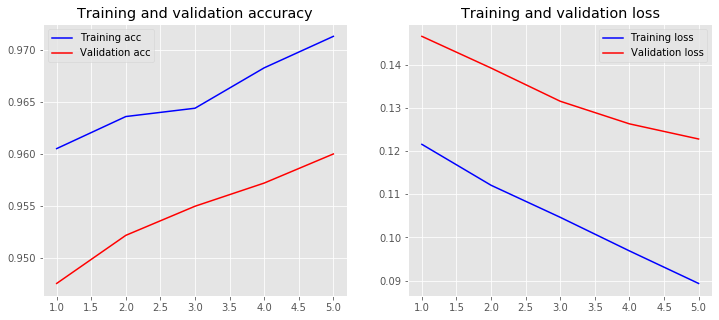

In [91]:
plot_history(history)
# График указывает, что стоит увеличить кол-во эпох

In [92]:
# https://www.tensorflow.org/tensorboard/get_started

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


history = model.fit(train_data.shuffle(10000).batch(512),
                    epochs=30,
                    validation_data=validation_data.batch(512),
                    verbose=1, 
                    callbacks=[tensorboard_callback])

Epoch 1/30
35/35 [==============================] - 3s 86ms/step - loss: 0.0820 - accuracy: 0.9746 - val_loss: 0.1183 - val_accuracy: 0.9612
Epoch 2/30
35/35 [==============================] - 3s 88ms/step - loss: 0.0787 - accuracy: 0.9759 - val_loss: 0.1171 - val_accuracy: 0.9621
Epoch 3/30
35/35 [==============================] - 3s 93ms/step - loss: 0.0707 - accuracy: 0.9790 - val_loss: 0.1143 - val_accuracy: 0.9635
Epoch 4/30
35/35 [==============================] - 3s 99ms/step - loss: 0.0651 - accuracy: 0.9811 - val_loss: 0.1104 - val_accuracy: 0.9671
Epoch 5/30
35/35 [==============================] - 3s 99ms/step - loss: 0.0606 - accuracy: 0.9828 - val_loss: 0.1073 - val_accuracy: 0.9685
Epoch 6/30
35/35 [==============================] - 4s 108ms/step - loss: 0.0552 - accuracy: 0.9855 - val_loss: 0.1051 - val_accuracy: 0.9695
Epoch 7/30
35/35 [==============================] - 3s 85ms/step - loss: 0.0505 - accuracy: 0.9870 - val_loss: 0.1037 - val_accuracy: 0.9711
Epoch 8/30
3

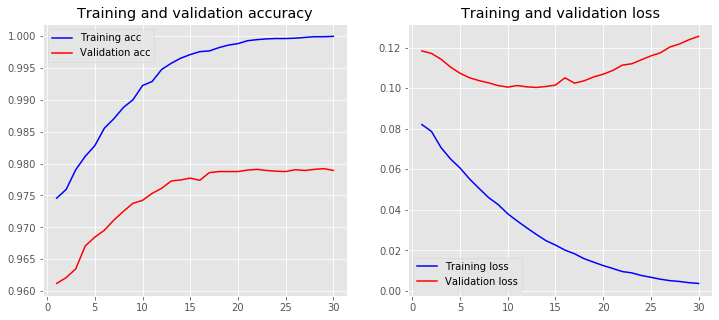

In [93]:
plot_history(history)
# Функция потерь минимальна при 10 эпохах. Это оптимальный параметр. Далее - переобучение?
# Метрика перестаёт растипри 20 эпохах